In [5]:
import pickle as pkl
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import seaborn
import pk_plot_library as pplib

In [6]:
# ds = pkl.load(open('/home/cosinga/hcolor/fig_md_analysis/bias_results.pkl', 'rb'))
# print(ds.getAttrs())


In [7]:
def makeBlueRedRatio(datalist):
    from figrid.data_container import DataContainer
    ip = {'color':'blue', 'color_cut':'0.60', 'path':['galbt', 'HIbt'], 'post_process':'no key found'}
    blues = datalist.getMatching(ip)
    ratiolist = []
    for dc in blues:
        mattr = copy.deepcopy(dc.attrs)
        rmattr = []
        for k in mattr:
            if 'runtime' in k or 'color' == k:
                rmattr.append(k)
        for rm in rmattr:
            del mattr[rm]
        mattr['color'] = 'red'
        mattr['post_process'] = 'no key found'
        reds = datalist.getMatching(mattr)
        if len(reds) > 1:
            print('%d corresponding reds for a blue:'%len(reds))
            print("BLUE ATTRS:")
            print(dc.attrs)
            print("RED ATTRS:")
            for r in reds:
                print(r.attrs)
        if len(reds) == 0:
            print('no reds found')
            print(dc.attrs)
        else:
            reds = reds[0]
            data = [dc.data[0], reds.data[1]/dc.data[1]]
            ratio = DataContainer(data)
            mattr['color'] = 'ratio' 
            ratio.update(mattr)
            ratiolist.append(ratio)
    return ratiolist
SPECS = {}
SPECS['all'] = ['box', 'simname', 'grid_resolution', 'snapshot', 'axis', 'path', 'mas', 'space']
SPECS['hisubhalo'] = ['model', 'HI_res', 'censat']
SPECS['galaxy'] = ['color', 'gal_species', 'gal_res', 'color_cut', 'censat']
SPECS['ptl'] = ['ptl_species']
SPECS['hiptl'] = ['model']
SPECS['vn'] = []
def makeBias(datalist, path):
    from figrid.data_container import DataContainer
    biaslist = []
    
    crosses = datalist.getMatching({'is_auto' : False, 'path':path})
    cx_count = 0
    pnt_threshold = 0.05
    for cx in crosses:
        fns = cx.get('fieldname').split('_')
        if 'dust' in fns:
            continue
        autos = []
        for f in range(len(fns)):
            attrlist = copy.deepcopy(SPECS['all'])
            attrlist.extend(SPECS[fns[f]])
            attr = {'is_auto':True, 'fieldname':fns[f]}
            for at in attrlist:
                attr[at] = cx.get(at)
            
            if 'censat' in attr:
                if '_' in attr['censat']:
                    attr['censat'] = attr['censat'].split('_')[f]
            matches = datalist.getMatching(attr)
            if len(matches)>1:
                print('too many matches %d'%len(matches))
                for m in matches:
                    print(m.attrs)
            elif len(matches) == 0:
                print('no matches found')
                print(attr)
                print(cx.attrs)
            else:
                auto = matches[0]
#                 data = [cx.data[0], cx.data[1] / auto.data[1]]
#                 dc = DataContainer(data)
#                 dc.update(copy.deepcopy(cx.attrs))
#                 dc.add('post_process', 'theory_bias')
#                 dc.add('numerator', cx.get('fieldname'))
#                 dc.add('denominator', auto.get('fieldname'))
#                 biaslist.append(dc)
                autos.append(auto)
        if len(autos) == 2:
#             for a in range(len(autos)):
#                 data = [autos[a].data[0], np.sqrt(autos[a].data[1] / autos[(a+1)%2].data[1])]
#                 dc = DataContainer(data)
#                 dc.update(copy.deepcopy(cx.attrs))
#                 dc.add('post_process', 'obs_bias')
#                 dc.add('numerator', autos[a].get('fieldname'))
#                 dc.add('denominator', autos[(a+1)%2].get('fieldname'))
#                 biaslist.append(dc)

            data = [autos[0].data[0], cx.data[1] / np.sqrt(autos[0].data[1] * autos[1].data[1])]
            dc = DataContainer(data)
            dc.update(copy.deepcopy(cx.attrs))
            dc.add('post_process', 'corr_coef')
            biaslist.append(dc)
        cx_count += 1
        if cx_count / len(crosses) >= pnt_threshold:
            print("calculated bias for %f"%pnt_threshold)
            pnt_threshold += 0.05
        del attr
    return biaslist

In [8]:
ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/8-12_pkdatasort.pkl', 'rb'))

In [10]:
ds.tickArgs(direction = 'in', labelsize = 14)
ds.legendArgs((-1,-1), frameon = False, loc = 'upper right', fontsize = 12)
ds.rowLabelArgs(pos = [0.05, 0.05], fontsize = 14, ha = 'left', va = 'bottom')
ds.colLabelArgs(pos = [0.5, 0.95], fontsize = 14, ha = 'center', va = 'top')
ds.axisArgs(xscale = 'log', yscale = 'log', xlim = [0.11866199299595938, 20])
ds.axisLabelArgs('both', {'fontsize':16})
ds.setOrder('space', ['real', 'redshift', 'rsd'])
ds.setOrder('snapshot', [99, 67, 50])
ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('HI_fieldname', ['hisubhalo', 'vn', 'hiptl'], ['Galaxy Centers', 'All Particles', 'Galaxies by Particle'])
ds.displayAs('fieldname', ['hisubhalo', 'vn', 'hiptl', 'ptl'], ['Galaxy Centers', 'All Particles', 'Galaxies by Particle', 'Matter'])
ds.displayAs('snapshot', [99, 67, 50], ['z = 0.0', 'z = 0.5', 'z = 1.0'])
ds.displayAs('color', ['blue', 'red', 'resolved'], [r'HI $\times$ Blue', r'HI $\times$ Red', r'HI $\times$ Galaxies'])
ds.plotArgs('color', 'red', {'color':'red'})
ds.plotArgs('color', 'blue', {'color':'blue'})
ds.plotArgs('color', 'resolved', {'color':'gray'})
ds.plotArgs('space', 'real', {'color':'green'})
ds.plotArgs('space', 'redshift', {'color':'orange'})
lowbin = r'10$^7 \leq$ M$_{\mathrm{HI}}$/M$_\odot$ $<$ 10$^8$'
midbin =r'10$^8 \leq$ M$_{\mathrm{HI}}$/M$_\odot$ $<$ 10$^9$'
highbin = r'10$^9 \leq$ M$_{\mathrm{HI}}$/M$_\odot$'
bins = ['low-bin', 'mid-bin', 'high-bin']
threshs = ['low-threshold', 'mid-threshold', 'high-threshold']
ds.displayAs('HI_res', bins, [lowbin, midbin, highbin])
ds.setOrder('HI_res', bins + threshs + ['diemer'])
colors = seaborn.color_palette('copper', len(bins) + 1)
colors.reverse()
for i in range(len(bins)):
    ds.plotArgs('HI_res', bins[i], {'color':colors[i]})
    ds.plotArgs('HI_res', threshs[i], {'color':colors[i]})
ds.plotArgs('HI_res', 'diemer', {'color':colors[-1], 'label':'No Cut'})

lowth = r'10$^7 \leq$ M$_{\mathrm{HI}}$/M$_\odot$'
midth =r'10$^8 \leq$ M$_{\mathrm{HI}}$/M$_\odot$'
highth = r'10$^9 \leq$ M$_{\mathrm{HI}}$/M$_\odot$'
ds.displayAs('HI_res', threshs, [lowth, midth, highth])

lowbin = r'2 $\times$ 10$^8 \leq$ M$_{\star}$/M$_\odot$ $<$ 10$^9$'
midbin =r'10$^9 \leq$ M$_{\star}$/M$_\odot$ $<$ 10$^{10}$'
highbin = r'10$^{10} \leq$ M$_{\star}$/M$_\odot$'
ds.displayAs('gal_res', bins, [lowbin, midbin, highbin])
ds.setOrder('gal_res', bins + threshs + ['diemer'])
colors = seaborn.color_palette('viridis', len(bins) + 1)
colors.reverse()
for i in range(len(bins)):
    ds.plotArgs('gal_res', bins[i], {'color':colors[i]})
    ds.plotArgs('gal_res', threshs[i], {'color':colors[i]})
ds.plotArgs('gal_res', 'diemer', {'color':colors[-1], 'label':'No Cut'})

lowth = r'2 $\times$ 10$^8 \leq$ M$_{\star}$/M$_\odot$'
midth =r'10$^9 \leq$ M$_{\mathrm{HI}}$/M$_\odot$'
highth = r'10$^{10} \leq$ M$_{\mathrm{HI}}$/M$_\odot$'
ds.displayAs('gal_res', threshs, [lowth, midth, highth])

ds.displayAs('censat', ['centrals', 'satellites', 'both', 'centrals_both', 'satellites_both', 'both_satellites', 'both_centrals'],
            ['Central Galaxies', 'Satellite Galaxies', 'Both', 'HI in Centrals', 'HI in Satellites', 'Satellite Galaxies', 'Central Galaxies'])

# HI auto bins

The row values for : ['no key found']
The column values for HI_res: ['low-bin', 'mid-bin', 'high-bin']


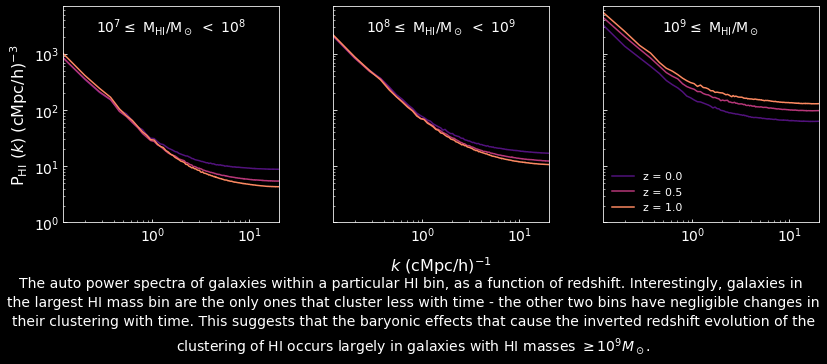

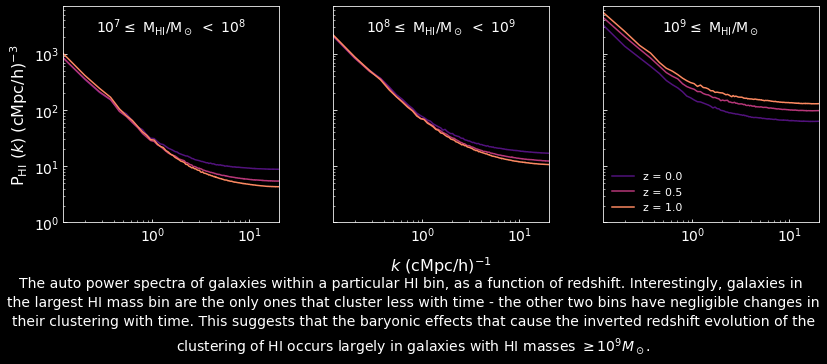

In [31]:
ip = {'fieldname':'hisubhalo', 'HI_res':['low-bin', 'mid-bin', 'high-bin'],
     'is_auto':True, 'censat':['no key found', None, 'both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['fiducial', 'HIbt'], 'simname':'tng100', 'snapshot':[99, 67, 50]}
WEBPATH = '/Users/cosinga/code/calvinosinga.github.io/papers/higal_cross/images/'
def fill_mean(ax, data, kwargs):
    x = data[0]
    y = np.mean(np.array([data[1], data[2]]), axis = 0)
    kwargs['alpha'] = 1
    ax.plot(x, y, **kwargs)
    return
fg = ds.figrid('snapshot', '', 'HI_res', ip)
fg.autoFill({'alpha':0.8})
fg.setFunc({'figrid_process':'fill'}, fill_mean)
fg.setYLabel(pplib.pklab('HI'))
fg.setXLabel(pplib.wnum())
fg.setDefaultTicksParams()
fg.setCmap('magma', [99, 67, 50])
fg.axisArgs({'ylim':(1, 7e3)})
fg.legendArgs({'fontsize':11}, loc = 'lower left')
pplib.darkmode(fg)
fg.plot()
fg.save(WEBPATH + 'HI-bins_auto_snapshot.png', dpi = 150)
f = open(WEBPATH + 'hi_auto_bins.txt', 'r')
text = f.read()
fg.fig.text(0.5, 0, text, color = 'white', ha = 'center', va = 'top', fontsize = 14, linespacing = 1.45)
fg.fig.savefig(WEBPATH + 'HI-bins_auto_caption.png', dpi = 250, facecolor = 'auto', bbox_inches = 'tight')
# fg.save('HI-bins_auto_snapshot_space.png')

In [23]:
ip['snapshot'] = 67
ip['HI_res'] = 'high-bin'
ds.printMatching(ip)

{'path': 'HIbt', 'result_type': 'pk', 'result_runtime': 37.231061697006226, 'is_auto': True, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 67, 'redshift': 0.5030475232448832, 'axis': 0, 'fieldname': 'hisubhalo', 'is_hydrogen': True, 'is_atomic': True, 'is_molecular': False, 'is_particle': False, 'is_groupcat': True, 'is_matter': False, 'mas': 'CICW', 'space': 'real', 'compute_xi': False, 'compute_slice': True, 'model': 'm_hi_GD14_map', 'projection': 'map', 'HI_res': 'high-bin', 'HI_fieldname': 'hisubhalo', 'censat': 'both'}

{'path': 'HIbt', 'result_type': 'pk', 'result_runtime': 34.06811022758484, 'is_auto': True, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 67, 'redshift': 0.5030475232448832, 'axis': 0, 'fieldname': 'hisubhalo', 'is_hydrogen': True, 'is_atomic': True, 'is_molecular': False, 'is_particle': False, 'is_groupcat': True, 'is_

# Making HI-bins figure for paper

Excluding the z=0.5 snapshot since it's mostly redundant. Also adding the HI/stmass histograms

The row values for snapshot: [99]
The column values for : ['no key found']


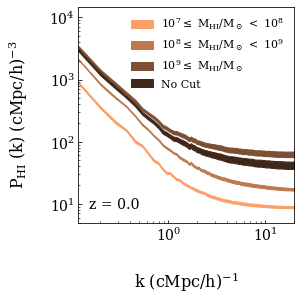

In [11]:
def mask_zeros(axis, data, kwargs):
    zeromask = data[1] > 0
    axis.fill_between(data[0][zeromask], data[1][zeromask], data[2][zeromask], **kwargs)
    return

ip = {'fieldname':'hisubhalo', 'HI_res':['diemer', 'low-bin', 'mid-bin', 'high-bin'],
     'is_auto':True, 'censat':['no key found', None, 'both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['fiducial', 'HIbt'], 'snapshot':99}
fg = ds.figrid('HI_res', 'snapshot', '', ip)
fg.plotArgs('diemer', {'label':'No Cut'})
fg.autoFill()
fg.setXLabel(XLAB)
fg.setYLabel(YLAB%r"\mathrm{HI}")
fg.legendArgs({'fontsize':11})
fg.axisArgs({'ylim':(5, 1.5e4)})
fg.plot()

The row values for : ['no key found']
The column values for : ['no key found']


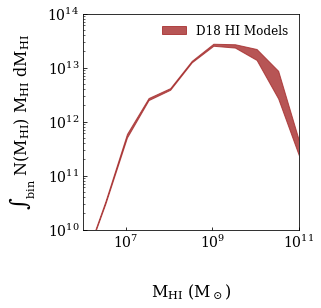

In [12]:
ip = {'is_hist':True, 'fieldname':'hisubhalo', 'is_hydrogen':True}
hifg = ds.figrid('model', '', '', ip)
hifg.fill(ip, {'color':'brown', 'alpha':0.8, 'label':'D18 HI Models'})
hifg.setFunc({'figrid_process':'fill'}, mask_zeros)
ypos = hifg.defaultAxLabelPos('y')
hifg.axisArgs({'xlim':(1e6, 1e11), 'ylim':(1e10, 1e14)})
hifg.setXLabel(r"M$_{\mathrm{HI}}$ (M$_\odot$)")
hifg.setYLabel(r"$\int_{\mathrm{bin}}$ N(M$_{\rm{HI}}$) M$_{\rm{HI}}$ dM$_{\rm{HI}}$", pos = [0.1, ypos[1]])
hifg.gspecArgs(xborder = [0.5, 0])
hifg.plot()

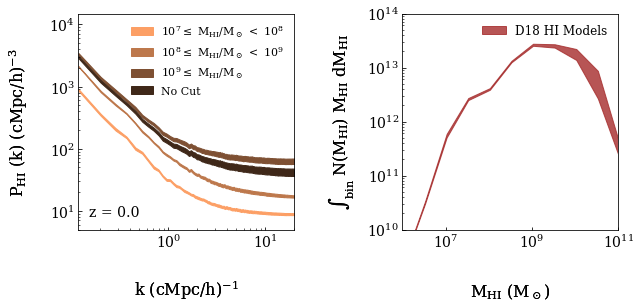

In [13]:
fig = ds.combine([fg, hifg])
fig.savefig(DRAFTPATH + 'HI_auto_bins_histogram.pdf', bbox_inches = 'tight')
fig.savefig('HI_auto_bins_histogram.png', bbox_inches = 'tight')

### Include this Figure

It shows that when one bins by HI mass for galaxies, the greater HI masses are more clustered than the smaller ones. The HI masses above 10$^9$ contribute more to the power spectrum than at any other mass.

Many other plots were made but may not have information worth it to include. Other things to describe:

* The power spectrum looks largely the same across different redshifts (so far we've tried z = 0, z = 0.5). 
* If we threshold instead, there is nearly no difference between the auto powers. Since highest HI bin contributes the most.
* If we split the cross-powers with galaxies of different colors into HI bins, the differences between the cross-powers is largely the same: i.e. blue and red galaxies do not preferentially cluster with some particular HI bin

# HIxGalaxy, for HI bins

The row values for snapshot: [99, 67]
The column values for : ['no key found']


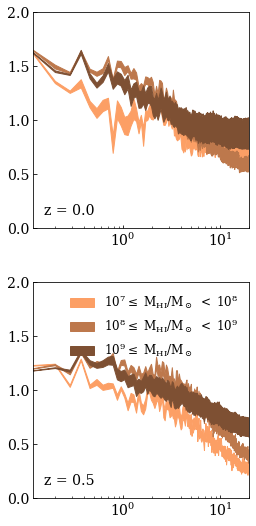

In [13]:
ip = {'is_auto':False, 'path':'HIbt', 'color':'ratio', 'censat':'both', 
      'HI_res':['low-bin', 'mid-bin', 'high-bin'], 'space':'real'}
fg = ds.figrid('HI_res', 'snapshot', '', ip)
fg.autoFill()
fg.axisArgs(yscale = 'linear', ylim = (0, 2))
fg.plot()

Showing that different HI masses do not preferentially belong to red or blue galaxies.

The row values for HI_res: ['low-bin', 'mid-bin', 'high-bin']
The column values for snapshot: [99, 67]


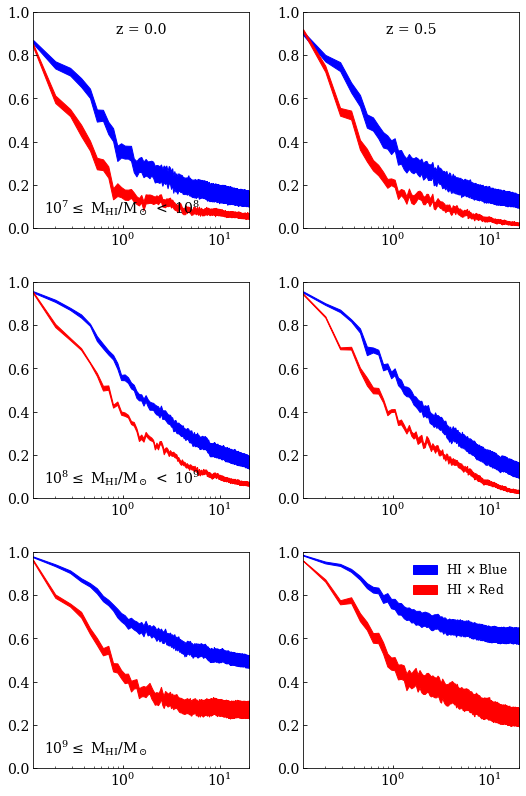

In [14]:
ip = {'is_auto':False, 'path':'HIbt', 'color':['blue', 'red'], 'censat':'both', 
      'HI_res':['low-bin', 'mid-bin', 'high-bin'], 'space':'real', 'post_process':'corr_coef'}
fg = ds.figrid('color', 'HI_res', 'snapshot', ip)
fg.autoFill()
fg.axisArgs(yscale = 'linear', ylim = (0, 1))
fg.plot()

Showing the same idea of exploring if some HI mass is more tightly correlated to one color or another. Doesn't seem to be the case

The row values for color: ['blue', 'red']
The column values for snapshot: [99, 67]


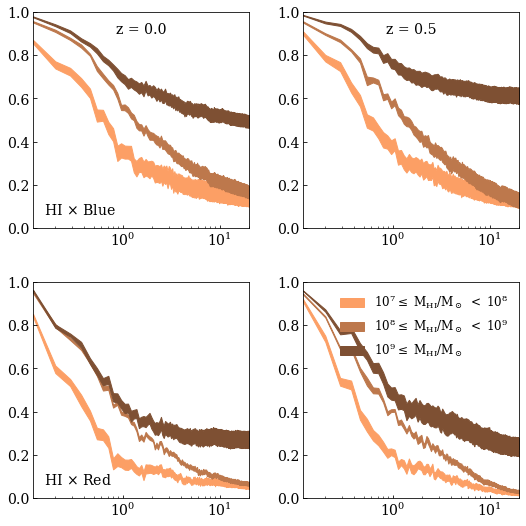

In [15]:
ip = {'is_auto':False, 'path':'HIbt', 'color':['blue', 'red'], 'censat':'both', 
      'HI_res':['low-bin', 'mid-bin', 'high-bin'], 'space':'real', 'post_process':'corr_coef'}
fg = ds.figrid('HI_res', 'color', 'snapshot', ip)
fg.autoFill()
fg.axisArgs(yscale = 'linear', ylim = (0, 1))
fg.plot()

# HI auto censat

The row values for censat: ['centrals', 'satellites', 'both']
The column values for snapshot: [99, 67]


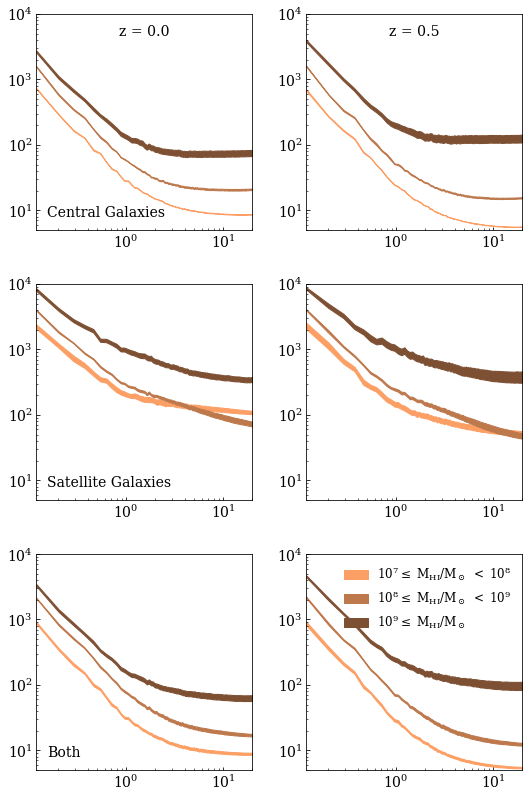

In [16]:

ip = {'fieldname':'hisubhalo', 'HI_res':['low-bin', 'mid-bin', 'high-bin'],
     'is_auto':True, 'censat':['centrals', 'satellites','both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['HIbt']}
fg = ds.figrid('HI_res', 'censat', 'snapshot', ip)
fg.axisArgs(ylim = (5, 1e4))
fg.autoFill()
fg.plot()

Interestingly, the HI auto power spectrum when separated into centrals and satellites, the smallest bin is actually larger than the intermediate bin. This isn't immediately apparent to me why this would be the case, but looking at how that is evolving with redshift it seems to me that this has to do with the kinds of galaxies that are transitioning into it. Would satellites in more clustered regions burn through HI faster than more isolated ones?

The row values for snapshot: [99, 67, 50]
The column values for : ['no key found']


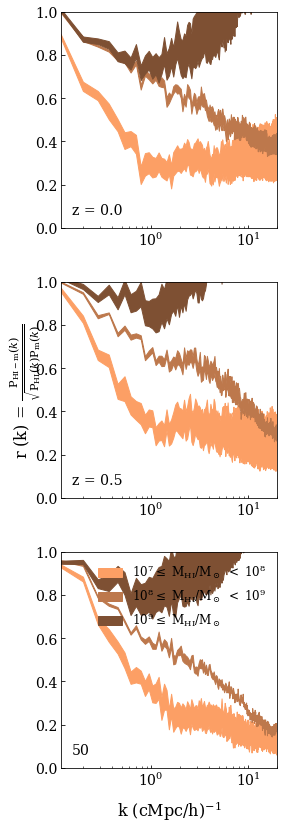

In [8]:
ip = {'HI_res':['low-bin', 'mid-bin', 'high-bin'],
     'is_auto':False, 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['HIbt'], 'post_process':'corr_coef', 'color':['blue', 'red'],
     'snapshot':[99, 67, 50], 'censat':['both']}
fg = ds.figrid('HI_res', 'snapshot', '', ip)
fg.autoNorm({'color':'blue'}, ['model'])
fg.setYLabel(CORRCOEF)
fg.setXLabel(XLAB)
fg.autoFill(alpha = 1)
fg.axisArgs(yscale = 'linear', ylim =(0, 1))
fg.plot()

Correlation coefficient, colors in different columns and HI divided into centrals/satellites populations in different rows. HI in satellite galaxies and blue galaxies are similarly tied across HI bins. The HI in central galaxies rarely have less than 10$^9$ solar masses

The row values for HI_res: ['low-bin', 'mid-bin', 'high-bin']
The column values for censat: ['satellites_both', 'centrals_both', 'both']


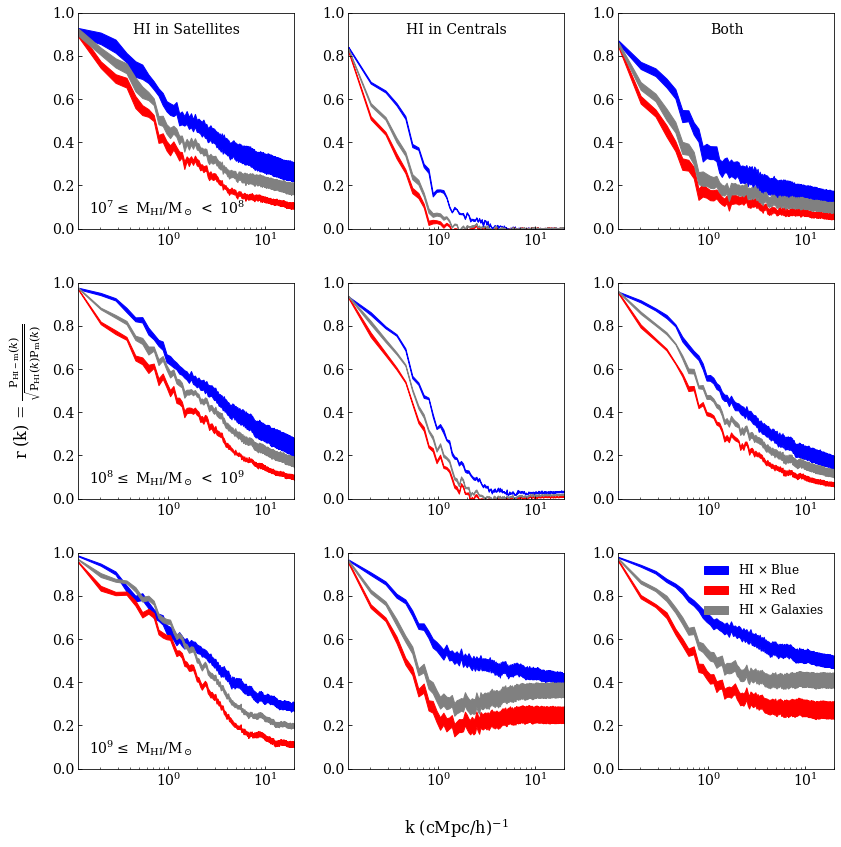

In [19]:
ip = {'HI_res':['low-bin', 'mid-bin', 'high-bin'],
     'is_auto':False, 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['HIbt'], 'post_process':'corr_coef', 'color':['blue', 'red', 'resolved'],
     'snapshot':99, 'censat':['satellites_both', 'centrals_both', 'both']}
fg = ds.figrid('color', 'HI_res', 'censat', ip)
fg.setYLabel(CORRCOEF)
fg.setXLabel(XLAB)
fg.autoFill()
fg.axisArgs(yscale = 'linear', ylim =(0, 1))
fg.plot()

Even splitting into centrals and satellites, still doesn't really change conclusions. Only somewhat strange panel is the bottom right - HI in satellites that have a mass greater than 10$^9$ don't favor blue galaxies as much as the rest of the correlation coefficient panels.

The row values for HI_res: ['low-bin', 'mid-bin', 'high-bin']
The column values for color: ['blue', 'red', 'resolved']


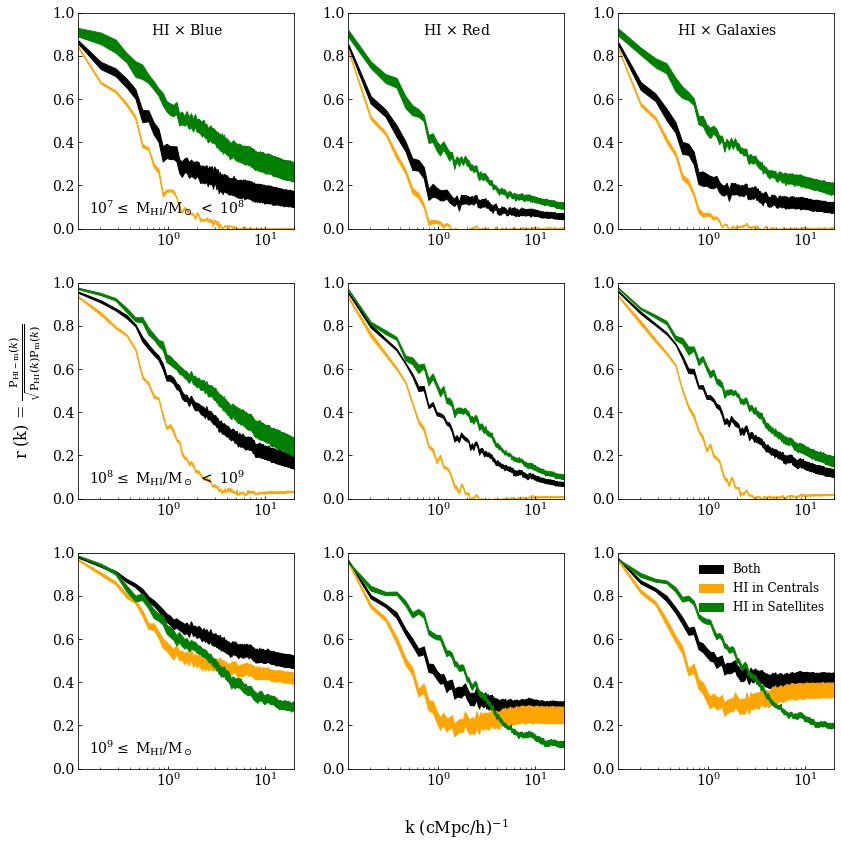

In [20]:
ip = {'HI_res':['low-bin', 'mid-bin', 'high-bin'],
     'is_auto':False, 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['HIbt'], 'post_process':'corr_coef', 'color':['blue', 'red', 'resolved'],
     'snapshot':99, 'censat':['satellites_both', 'centrals_both', 'both']}
fg = ds.figrid('censat', 'HI_res', 'color', ip)
fg.plotArgs('centrals_both', color = 'orange')
fg.plotArgs('satellites_both', color = 'green')
fg.plotArgs('both', color = 'black')
fg.autoFill()
fg.axisArgs(yscale = 'linear', ylim =(0, 1))
fg.setYLabel(CORRCOEF)
fg.setXLabel(XLAB)
fg.plot()

With the exception of the highest HI mass bin, HI in general belongs to satellites.

# HI thresholds auto power

The row values for snapshot: [99, 67]
The column values for : ['no key found']


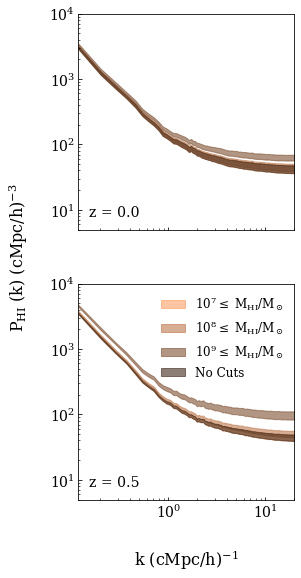

In [31]:
ip = {'fieldname':'hisubhalo', 'HI_res':['diemer', 'low-threshold', 'mid-threshold', 'high-threshold'],
     'is_auto':True, 'censat':['no key found', None, 'both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['fiducial', 'HIbt']}
fg = ds.figrid('HI_res', 'snapshot', '', ip)
fg.plotArgs('diemer', {'label':'No Cuts'})
fg.autoFill({'alpha':0.6})
fg.setYLabel(YLAB%r"\mathrm{HI}")
fg.setXLabel(XLAB)
fg.setDefaultTicksParams()
fg.axisArgs({'ylim':(5, 1e4)})
fg.legendArgs({}, (-1,-1))
fg.plot()
# fg.save('HI-thresholds_auto_snapshot_space.png')

Largely, no difference between the thresholds. Most of the contribution comes from the galaxies with the most HI. See the HI auto power with different bins instead of thresholds

# HI-Galaxy Cross Power Bins

The row values for color: ['blue', 'red', 'resolved']
The column values for snapshot: [99, 67]


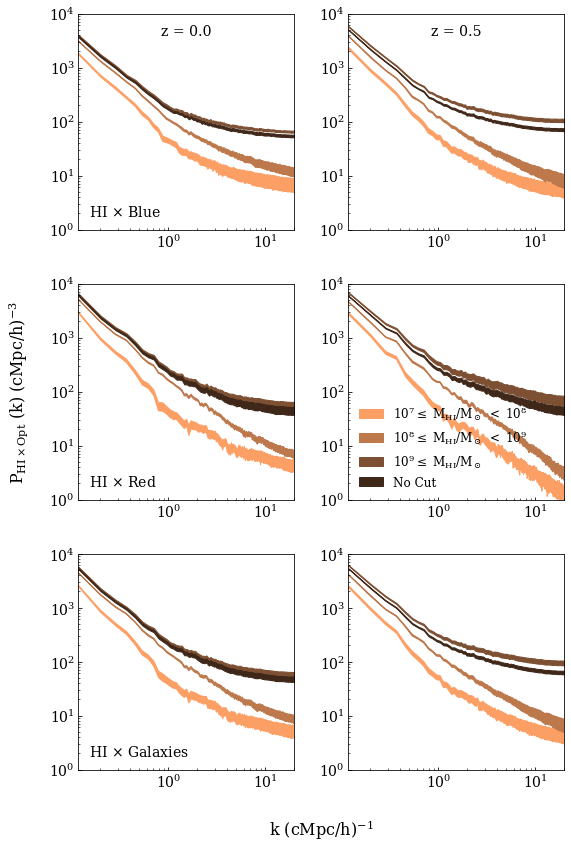

In [32]:
ip = {'HI_fieldname':'hisubhalo', 'HI_res':['diemer', 'low-bin', 'mid-bin', 'high-bin'],
     'is_auto':False, 'censat':['no key found', None, 'both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['fiducial', 'HIbt'], 'gal_res':'diemer', 'color':['blue', 'red', 'resolved'],
     'color_cut':['0.60', 'None'], 'post_process':'no key found'}
fg = ds.figrid('HI_res', 'color', 'snapshot', ip)
fg.legendArgs({'loc':'lower left'}, (1, 1))
fg.axisArgs(ylim = (1, 1e4))
fg.setYLabel(YLAB%r'\mathrm{HI} \times \mathrm{Opt}')
fg.setXLabel(XLAB)
fg.autoFill(alpha = 1)
fg.plot()

This plot doesn't look very different from the HI auto power. Again shows that blue/red galaxies don't prefer to cluster with the HI bin masses.

The row values for snapshot: [99, 67]
The column values for HI_res: ['diemer', 'low-bin', 'mid-bin', 'high-bin']


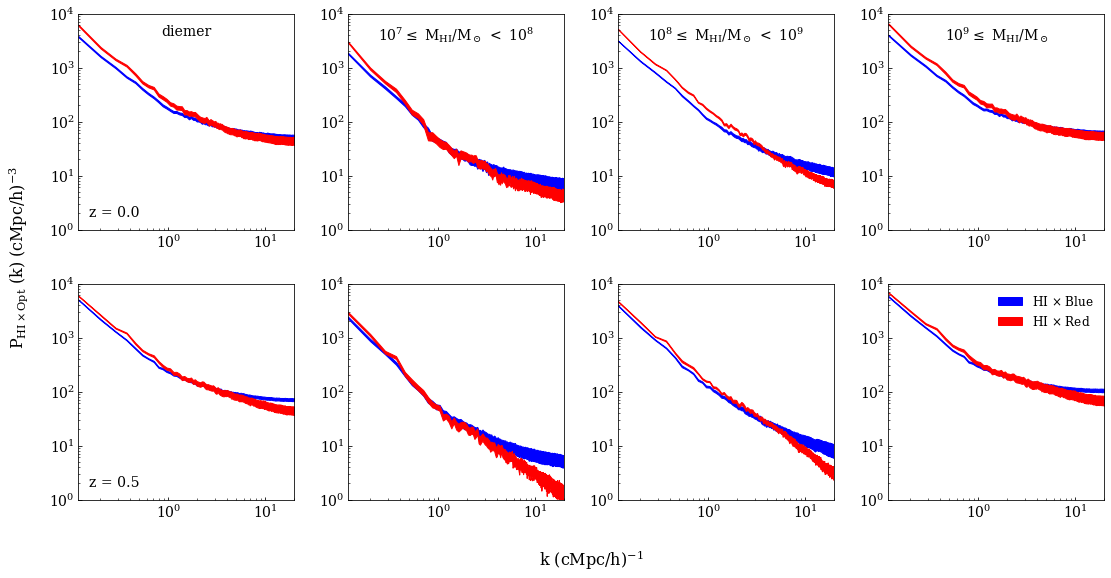

In [33]:
ip = {'HI_fieldname':'hisubhalo', 'HI_res':['diemer', 'low-bin', 'mid-bin', 'high-bin'],
     'is_auto':False, 'censat':['no key found', None, 'both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['fiducial', 'HIbt'], 'gal_res':'diemer', 'color':['blue', 'red'],
     'color_cut':['0.60', 'None'], 'post_process':'no key found'}
fg = ds.figrid('color', 'snapshot', 'HI_res', ip)
fg.axisArgs(ylim = (1, 1e4))
fg.setYLabel(YLAB%r'\mathrm{HI} \times \mathrm{Opt}')
fg.setXLabel(XLAB)
# fg.legendArgs({'loc':'lower left'}, (1, 1))
fg.autoFill()
fg.plot()

Again, shows largely no color preference for one color or another amongst HI bins.

The row values for color: ['blue', 'red', 'resolved']
The column values for HI_res: ['diemer', 'low-bin', 'mid-bin', 'high-bin']


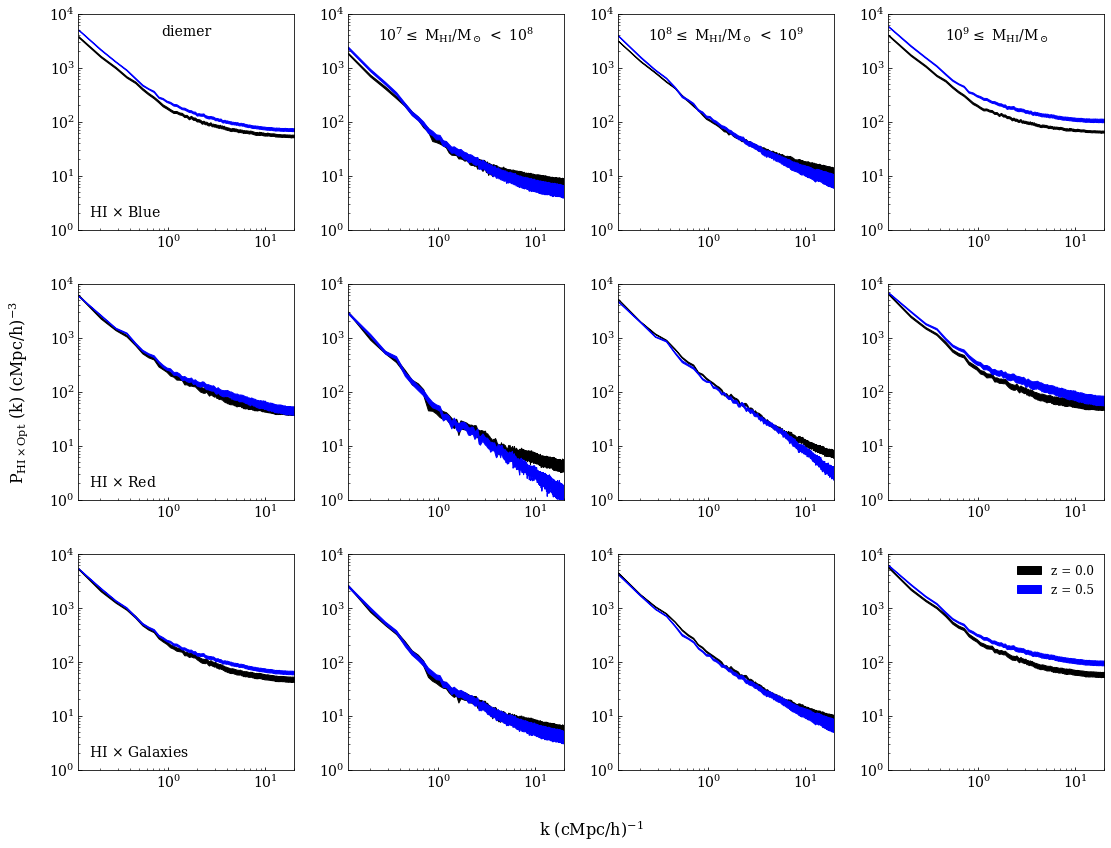

In [34]:
ip = {'HI_fieldname':'hisubhalo', 'HI_res':['diemer', 'low-bin', 'mid-bin', 'high-bin'],
     'is_auto':False, 'censat':['no key found', None, 'both'], 'sim_resolution':'high', 'space':'real',
     'grid_resolution':800, 'path':['fiducial', 'HIbt'], 'gal_res':'diemer', 'color':['blue', 'red', 'resolved'],
     'color_cut':['0.60', 'None'], 'post_process':'no key found'}
fg = ds.figrid('snapshot', 'color', 'HI_res', ip)
fg.axisArgs(ylim = (1, 1e4))
# fg.legendArgs({'loc':'lower left'}, (1, 1))
fg.autoFill()
fg.setYLabel(YLAB%r'\mathrm{HI} \times \mathrm{Opt}')
fg.setXLabel(XLAB)
fg.plotArgs(99, color = 'black')
fg.plotArgs(67, color = 'blue')
fg.plot()

Most of the redshift evolution occurs in the highest HI mass bin